## Parameter Synthesis and Optimization

### Stochpy Introduction

This small tutorial is going to show how to use the module **stochpy** and how to mix it with **Moonlight** to do *parameter synthesis*. 

StochPy is a Python module designed for stochastic simulation. To install stochPy you can use pip (pip install StochPy). 
It provides a good number of models written using PySCeS (Python Simulator for Cellular Systems). 
We will use the default model, that is "ImmigrationDeath.psc". $\newline$
  
From **stochpy** documentation
>    We call this the Immigration-death model which we use as the default model in StochPy. Here, we define two reactions: a zero-order reaction R1 synthesizing the species mRNA and a first-order reaction R1 degrading mRNA. Next, we set an initial mRNA copy number and finally the parameter values of the synthesis and degradation rate.

The first reaction is associated with parameter Ksyn, the second one with Kdeg.
The mRNA initial value is fixed, but it can be changed.

All the stochpy example models are saved in 'C:\Stochpy\pscmodels'. 

(Might be different if you are not using Windows. After compiling the cell with the modules, a small description of StochPy will tell you where model folder is.) 


For more insights on the StochPy module, follow the online documentation: 
-    https://pythonhosted.org/StochPy/modules_doc.html
-    http://stochpy.sourceforge.net/html/userguide_doc.html

In [2]:
## Basic modules always useful
import numpy as np
# import random
import math

# import time
# import os

import warnings

## Importing moonlight locally
from moonlight import *

## For plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8) 
# plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib import colors


## Gaussian processes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ



## Stochastic Simulation
from stochpy import SSA

D:\Indispensabili\Anaconda\Library
D:\Indispensabili\Anaconda\Library

#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                 

**Major warning**: after running the cell where the module stochpy is imported, the current working directory is changed.
You can easily check it running *os.getcwd( )* before and after importing this module. Luckily it doesn't affect the run of the code.

Sadly this problem can't be solved globally. Remember this if you intend to "put your hands on the code". This leads to a problem in loading local files. You still can do it (probabily) using full paths from the root, but I have yet to check.

### Starting the simulation

The following functions simulate the Immigration-Death model from the StochPy module.

It is prepared to run using default parameters. 
Some details will be printed directly by the function *StochasticModellingWithParameters()*.

If you want to inspect the functions, they have a bit of documentation.
-    ImmigrationDeathSSA(Ksyn, Kdeg, ltime, n_samples): it simulates one time the model using the parameters in input. It return the SSA, so it can be inspected indipendently as stochpy object;

-    getSpeciesTimeSeriesAsArray(ssa): using some inner stochpy notation, it is possible to extract the trajectories from the simulation. It takes in input the SSA object and returns an multi-dimensional array, where the first position refers to the trajectory, the others are the time steps and the value;

-    StochModel(n_traj, ltime, Ksyn, Kdeg): one run of this function will simulate a set of *n_traj* trajectories for the couple of parameters in input, each of length *ltime*. It return a couple of values: they are the average robustness for the two formulas used for the monitoring;

-    StochasticModellingWithParameters(ltime, n_traj, parameterKsyn, parameterKdeg, model): this function repeats the simulation for all the possible couple of parameters $(Ksyn, Kdeg) \in \text{parametersKsyn} \times \text{parametersKdeg}$. 

They take parameter in input such as the length of the time interval, the number of trajectories for each run, the parameters, ..
This is already set up by default to have nice results, but inspecting the code you can change a lot of details, like the set of parameters, the formulas, the time interval, ...

The default function takes a half a minute to execute. 

In [3]:
def ImmigrationDeathSSA(Ksyn = 18, Kdeg = None, ltime = 40, n_traj = 1):
     """
     This function return an object that is the result of the stochastic simulation of the 
     Immigration-Death model ("ImmigrationDeath.psc" or default model). 

     stochpy.SSA() call the stochastic simulation algorithm for the model in input, 
          the default is model_file = "ImmigrationDeath.psc".
     ssa.ChangeParameter() does exactly what it seems, takes as first argument 
          the name of the parameter between quotation marks and as second argument the new value.
          This means that you need to know which are the parameters of the model.
     ssa.DoStochSim() simulate one run of the model. The parameter trajectories can be added
          to have more simulation on the same object.
     """

     ssa = SSA()

     ssa.ChangeParameter("Ksyn", Ksyn)
     if Kdeg:
          ssa.ChangeParameter("Kdeg", Kdeg)

     ssa.DoStochSim(end = ltime, mode = 'time', trajectories = n_traj)

     return ssa


def getSpeciesTimeSeriesAsArray(ssa):
     """
     This function extract the data of the simulation trajectory(ies) and it saves them in two lists, 
          one for the time steps and one for the values.  

     The following is stochpy inner code, I suggest to check the documentation of
          stochpy and/or the actual code of the module (or you can trust me).
     """
     assert ssa._IsSimulationDone, "First do a stochastic simulation"  
     timeSignalValues = list()
     values = list()
     for n in range(1,ssa.sim_trajectories_done+1):
          if ssa.sim_trajectories_done > 1:
               ssa.GetTrajectoryData(n)          
          for timepoint in ssa.data_stochsim.getSpecies():
               timeSignalValues.append(timepoint[0])
               values.append([timepoint[1]])

     return timeSignalValues, values


def StochModel(     n_traj = 8, 
                    ltime = 40,   
                    Ksyn = 18,
                    Kdeg = None,
                    script = None,
                    trajectories = True     ):

     Ksyn = float(Ksyn)
     
     n_samples = 10*ltime + 1 
     robustness = list()

     count = 0
     plot_traj = 0

     for traj in range(n_traj):
          
          ssa = ImmigrationDeathSSA(Ksyn = Ksyn, ltime = ltime)
          timeSignalValues, signal = getSpeciesTimeSeriesAsArray(ssa)

          if not script:
               script = """
               signal { real values;   }
               domain minmax; 
               formula phi = globally [10, 40] ( ((values > 90) & (values < 150 )) | ( (values > 200) & (values < 300) ) ) ;
               """

          moonlightScript = ScriptLoader.loadFromText(script)
          monitor = moonlightScript.getMonitor("phi")

          result = np.array(monitor.monitor(timeSignalValues, signal))
          
          robustness.append(result.transpose()[1])
          if (robustness[traj] >= 0):
               count += 1

          if trajectories == True:
               if plot_traj == 0:          
                    # PlottingDetailsStochModel(timeSignalValues = timeSignalValues, signal = signal, trajectories = trajectories, plot_all = False)
                    t = timeSignalValues
                    n_samples = len(t)
                    plt.plot(t, signal, color = 'red', linewidth = 0.5)
                    maxT1 = np.zeros(n_samples) + 150
                    minT1 = np.zeros(n_samples) + 90
                    maxT2 = np.zeros(n_samples) + 200
                    minT2 = np.zeros(n_samples) + 300
                    
                    verticalTimeLine1 = [[10, 10], [90, 150]]
                    verticalTimeLine2 = [[10, 10], [200, 300]]

                    plt.plot(t, maxT1, 'blue', linewidth = 2, linestyle = 'dashed')
                    plt.plot(t, minT1, 'blue', linewidth = 2, linestyle = 'dashed')
                    plt.plot(t, maxT2, 'blue', linewidth = 2, linestyle = 'dashed')
                    plt.plot(t, minT2, 'blue', linewidth = 2, linestyle = 'dashed')

                    plt.plot(verticalTimeLine1[0], verticalTimeLine1[1], color = "green", linestyle = 'dashed')
                    plt.plot(verticalTimeLine2[0], verticalTimeLine2[1], color = "green", linestyle = 'dashed')
                    
                    plot_traj += 1
               
     satProb = count/n_traj  


     return np.mean(robustness), satProb


def StochasticModellingWithParameters(  ltime = 40,
                                        n_traj = 60, 
                                        parameterKsyn = np.arange(14, 45, 2.5),
                                        parameterKdeg = None,
                                        script = None,
                                        plot_all = True,
                                        trajectories = False      ):

     lSyn = len(parameterKsyn)

     robustnessResults = np.zeros(lSyn)
     satProb = np.zeros(lSyn)

     # print("The number of time steps is ", ltime)
     # print("The number of trajectories for each simulation is ", n_traj)
     # print()

     # print("Interval extremes for Ksyn: \t[ ", parameterKsyn[0], ",\t", round(parameterKsyn[-1], 1), "]")
     # print("The interval has ", lSyn, " steps, each of length ", round((parameterKsyn[-1]-parameterKsyn[0])/(lSyn-1), ndigits = 2))
     # print()
     
     # print("The formula is:")
     # print("-\tphi1 = globally [ 10, {} ] ( ( (values > 90) & (values < 150)  ) | ( (values > 200) & (values < 300) ) );".format(ltime))
     # print()

     
     for syn in range(lSyn):          
          robustnessResults[syn], satProb[syn] = StochModel(Ksyn = parameterKsyn[syn], n_traj = n_traj, script = script, trajectories = trajectories)
          print(round((syn+1)*100/lSyn, ndigits = 1), "% complete..")
     
     PlottingDetailsStochModel(k = parameterKsyn, sat = satProb, rob = robustnessResults, 
                                   plot_all = plot_all, trajectories = trajectories)

     return robustnessResults, satProb


def PlottingDetailsStochModel(     k = None, 
                                   sat = None, 
                                   rob = None,

                                   timeSignalValues = list(),
                                   signal = list(),

                                   plot_all = False,
                                   trajectories = False      ):
     if plot_all:
     
          fig, axs = plt.subplots(3, 1, figsize = (10, 30))
          # fig.suptitle('Plotting robustness and satisfaction probability over the set of parameters K')

          z = [[0, max(sat)], [0, 0]]

          axs[0].plot(sat, rob, 'b*', markersize = 14)
          axs[0].plot(z[0], z[1], linestyle = 'dashed')
          axs[0].set(xlabel = 'Satisfaction probability', ylabel = 'Robustness')
          axs[0].title.set_text('Robustness value over the satisfaction probability')

          axs[1].plot(k, sat, 'ro', markersize = 14)
          axs[1].set(xlabel = 'Ksyn', ylabel = 'Satisfaction probability')
          axs[1].title.set_text('Satisfaction probability over the set of parameters')
          
          axs[2].plot(k, rob, 'g*', markersize = 14)
          axs[2].set(xlabel = 'Ksyn', ylabel = 'Robustness')
          axs[2].title.set_text('Robustness value over the set of parameters and gp regressor')
     
     if trajectories:
          
          t = timeSignalValues
          n_samples = len(t)
          plt.plot(t, signal, color = 'red', linewidth = 0.5)
          maxT1 = np.zeros(n_samples) + 150
          minT1 = np.zeros(n_samples) + 90
          maxT2 = np.zeros(n_samples) + 200
          minT2 = np.zeros(n_samples) + 300
          
          verticalTimeLine1 = [[10, 10], [90, 150]]
          verticalTimeLine2 = [[10, 10], [200, 300]]

          plt.plot(t, maxT1, 'blue', linewidth = 2, linestyle = 'dashed')
          plt.plot(t, minT1, 'blue', linewidth = 2, linestyle = 'dashed')
          plt.plot(t, maxT2, 'blue', linewidth = 2, linestyle = 'dashed')
          plt.plot(t, minT2, 'blue', linewidth = 2, linestyle = 'dashed')

          plt.plot(verticalTimeLine1[0], verticalTimeLine1[1], color = "green", linestyle = 'dashed')
          plt.plot(verticalTimeLine2[0], verticalTimeLine2[1], color = "green", linestyle = 'dashed')

          plt.xlabel('Time')
          plt.ylabel('Population value')


To understand what is the main object of this example, I will show a simple run of the Immigration-Death model using the Stochastic Simulation Algorithm (SSA) of stochpy.

Everything is made to run as default, but you can play with the parameters.

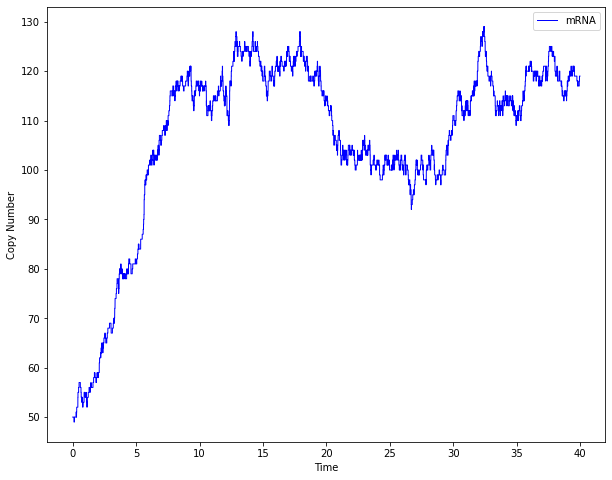

In [4]:
ssa1 = ImmigrationDeathSSA()
ssa1.PlotSpeciesTimeSeries()

You can increase the number of trajectories simulated on the same object.

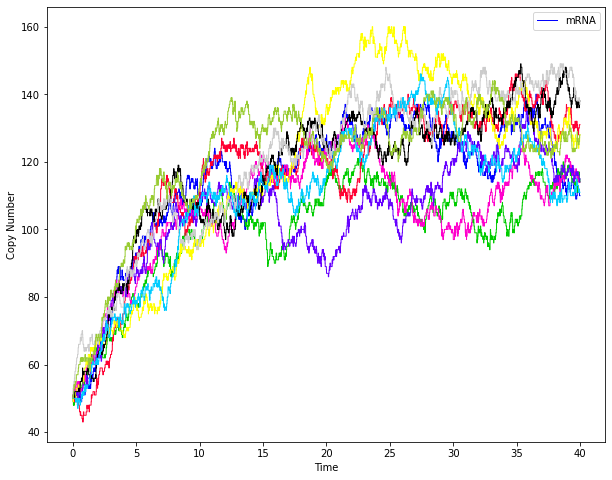

In [5]:
ssa10 = ImmigrationDeathSSA(n_traj = 10)
ssa10.PlotSpeciesTimeSeries()

The last example shows how to play with all the parameters of the function, the length of the simulation, the synthesis and degradation parameters and the number of trajectories.

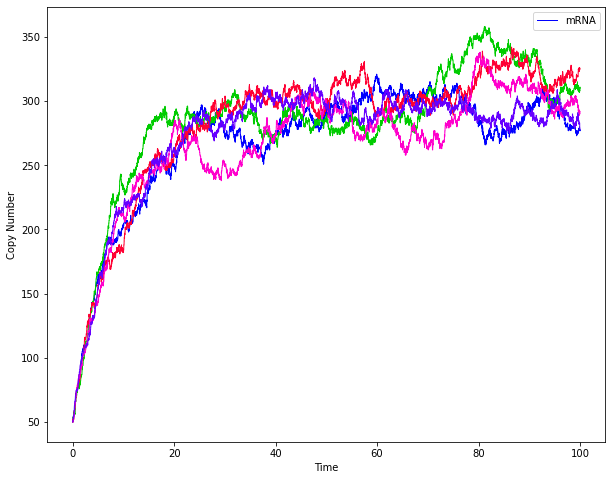

In [28]:
ssaNewPar = ImmigrationDeathSSA(Ksyn = 30, Kdeg = 0.1, n_traj = 5, ltime = 100)
ssaNewPar.PlotSpeciesTimeSeries()

### Stochastic Simulation over a set of parameters

For each parameter in *parameterKsyn* ( = [ 14, 16.5, .., 40.0, 42.5 ] ) we simulate multiple trajectories. It dependes on the model, usually 80-100 is good number. Then we extract the average robustness and the satisfaction probability. 

7.7 % complete..
15.4 % complete..
23.1 % complete..
30.8 % complete..
38.5 % complete..
46.2 % complete..
53.8 % complete..
61.5 % complete..
69.2 % complete..
76.9 % complete..
84.6 % complete..
92.3 % complete..
100.0 % complete..


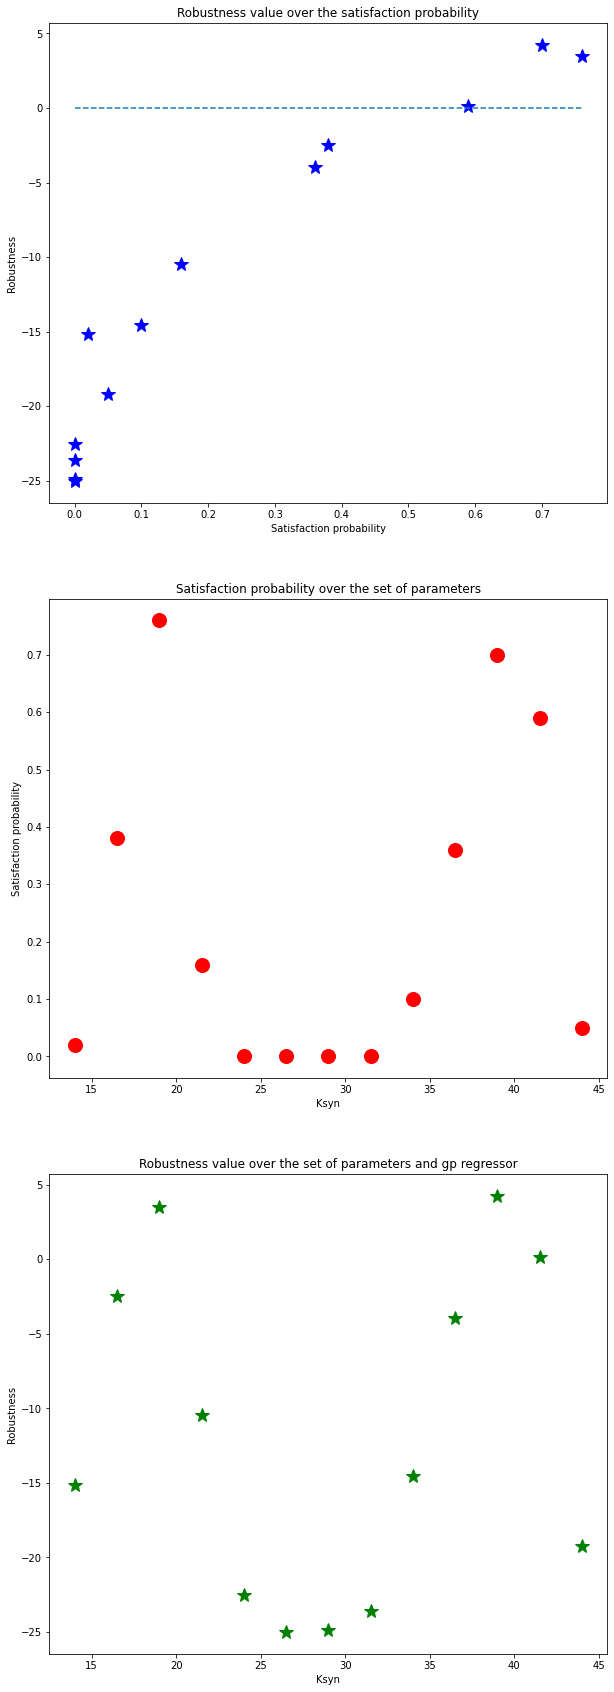

In [4]:
script = """
signal { real values;   }
domain minmax; 
formula phi = globally [10, 40] ( ((values > 90) & (values < 150 )) | ( (values > 200) & (values < 300) ) ) ;
"""

rob, sat = StochasticModellingWithParameters(script = script, n_traj = 100)

### Gaussian Process Upper Confidence Bound (GP-UCB) Algorithm

We will use Gaussian Process Regressor to obtain an approximation of the Robustness values over the parameter set *parameterKsyn* of the model. The first case will inspect the problem looking at parameter Ksyn, later on it will be extended to a bidimensional optimization.

The optimization procedure follows Gaussian Process Upper Confidence Bound (GP-UCB) algorithm. Basically instead of focusing on the predicted values using the GPR, we take what is called the upper confidence bound: it's just the result of sum of the mean prediction of the GPR and the standard deviation multiplied by some parameter linked to the confidence we are looking for (95% for us, so $\beta = 1.96$). More formally, 
$$ucb = pred + \beta \cdot \sigma.$$
We take the position where maximum of this new function is (new_param) and simulate the model for that singular parameter, obtaining a true value (y_simulated).
Then the couple (new_param, y_simulated) is added to the set of observation used to fit the gaussian process regressor.

This procedure converge quite fast. The default stopping criteria (in my code) is called "SameX": when in two consecutive iteration the parameter chosen is the same, it means that the previous simulation already gave the best result, then it stops.

In [15]:
def GP_UCB(k, rob, seed = 4, noise_level = 0.5, kernel = None, stopping_criteria = "SameX", single_frame_plot = False):
     
     # The GP regressor often gives warning about the restart of the procedure, but it doesn't affect the 
     #    result so I suppressed the warnings.
     warnings.filterwarnings("ignore")

     np.random.seed(seed)

     ## Set where we predict
     x = np.atleast_2d(np.linspace(14, 45, 500)).T

     ## Lists for the intervals where the maximum is and its value
     predMaxInterval = list()
     xMaxInterval = list()

     ## Training sets
     training_indices = np.random.randint(1, len(k)-1, size = 10).tolist()
     training_indices.append(0)
     training_indices.append(len(k)-1)
     # trining_indices = np.arange(len(k))

     X = np.atleast_2d(k[training_indices]).T
     X = X.tolist()

     y = rob[training_indices].tolist()     
     maxDistance = max(rob[training_indices]) - min(rob[training_indices])

     ## Kernel and GPR initialization
     if not kernel:
          kernel = C(1.0) * RBF(18, (1e-2, 1e2))
     gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 20, alpha = noise_level)


     while True:

          ## Just the transparency of the filling area in the plots
          if single_frame_plot:
               alpha = 0.4
          else:
               alpha = 0.1

          ## Fitting of the GP 
          gp.fit(X, y)

          ## Prediction of y and standard deviation
          y_pred, std_pred = gp.predict(x, return_std=True)
 
          ## Upper confidence bound (UCB) and lower confidence bound (LCB) 
          support_y = y_pred + 1.96*std_pred
          lower_support_y = y_pred - 1.96*std_pred
          verticalLine = [[x[np.argmax(support_y)], x[np.argmax(support_y)]], [max(support_y), lower_support_y[np.argmax(support_y)]]]
          
          ## Plotting (create a separate function?)
          # fig = plt.subplots(1, 1, figsize = (10, 8))
          GP_plotting(k, rob, X, y, x, y_pred, std_pred, verticalLine, alpha)
          if single_frame_plot:
               plt.show()
          else:
               print("Iteration number ", len(y[11:]))

          X.append((x[np.argmax(support_y)]).tolist())
                    
          tempRob, tempSat = StochasticModellingWithParameters(parameterKsyn = X[-1], n_traj = 80, plot_all = False, trajectories = False) 
          y.append(tempRob)

          if stopping_criteria == "SameX":
               # # Check if two successive new elements are equal, then break
               # # Not feasible now that I've added the random component to the new parameter
               if X[-1] == X[-2]:
                    break

          elif stopping_criteria == "NoImprovement":
               ## Check if the improvement between two iteration is small enough to stop
               ## Not feasible now that I've added some noise in the gaussian process regressor (alpha) 
               if abs(y[-1] - y[-2]) <= 0.3:
                    break
          
          elif stopping_criteria == "StdConverge":
               if len(y[11:]) > 2:
                    yhat = np.mean(y[11:])
                    se = 1/len(y[11:])**3 * math.sqrt(sum((yhat - y[11:]) ** 2))
                    if abs(se) <= 2e-2:
                         break

          xMaxInterval.append(X[-1])
          predMaxInterval.append(max(y_pred).tolist())
     
     # if not single_frame_plot:
     #      plt.show()
     
     return X[-1], max(y_pred)


def GP_plotting(k, rob, X, y, x, y_pred, std_pred, verticalLine, alpha):

     plt.plot(k, rob, 'g*', markersize = 6)
     plt.plot(X, y, 'r.', markersize = 15, label = u'Observations')
     plt.plot(x, y_pred, 'b-', label = u'Prediction')
     plt.fill(np.concatenate([x, x[::-1]]),
          np.concatenate([y_pred - 1.96*std_pred,
                         (y_pred + 1.96*std_pred)[::-1]]),
          alpha = alpha, fc = 'orange', ec = 'None', label = '95% confidence interval' )
     # plt.legend(loc='lower right')
     plt.xlabel('$Ksyn$')
     plt.ylabel('$Robustness$')
     plt.plot(verticalLine[0], verticalLine[1], color = 'red')


def CompleteParameterSynthesis(k = np.arange(14, 45, 2.5), n_traj = 80):
     rob, sat = StochasticModellingWithParameters(parameterKsyn = k, n_traj = n_traj, plot_all = True)

     print("\nThe simulation for the set of parameters K is done.\n")
     print("The creation of the gaussian process regressor will start.")
     print("After each iteration the algorithm Gaussian Process Upper Confidence Bound (GP-UCB) will get closer to the maximum.\n")

     X, Y = GP_UCB(k, rob, single_frame_plot = False, noise_level = 0.5)

     print()
     print(X[np.argmax(Y).tolist()], max(Y))


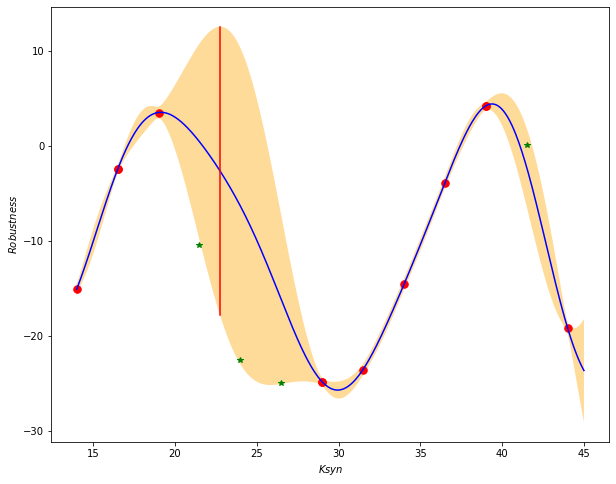

100.0 % complete..


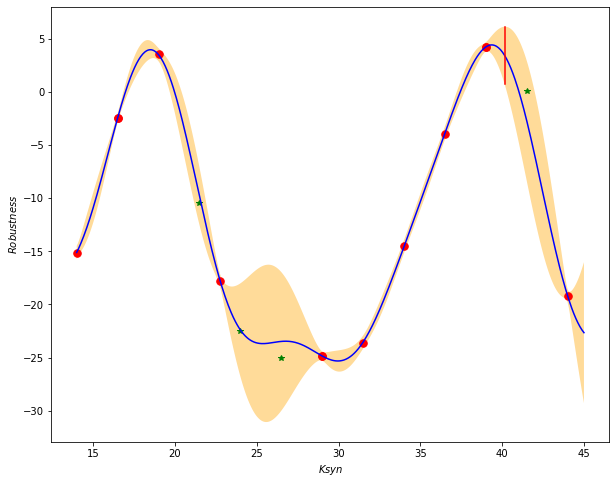

100.0 % complete..


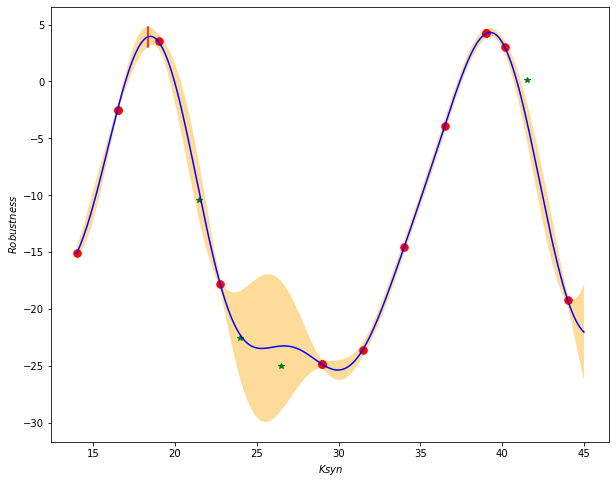

100.0 % complete..


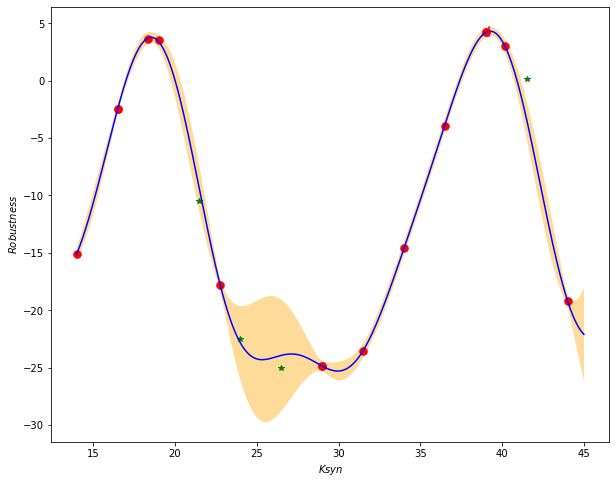

100.0 % complete..


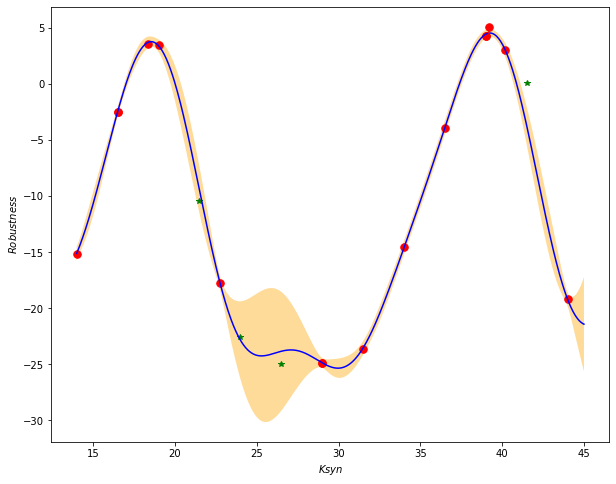

100.0 % complete..


([39.22244488977956], 4.545963317877522)

In [16]:
GP_UCB(k = np.arange(14, 45, 2.5), rob = rob, single_frame_plot = True, noise_level = 0.1, seed = 1)

Everything is run together in the following function: you can directly interact with the parameters of the function to understand how it works, but can also be run with default parameters.

7.7 % complete..
15.4 % complete..
23.1 % complete..
30.8 % complete..
38.5 % complete..
46.2 % complete..
53.8 % complete..
61.5 % complete..
69.2 % complete..
76.9 % complete..
84.6 % complete..
92.3 % complete..
100.0 % complete..

The simulation for the set of parameters K is done.

The creation of the gaussian process regressor will start.
After each iteration the algorithm Gaussian Process Upper Confidence Bound (GP-UCB) will get closer to the maximum.

Iteration number  1
100.0 % complete..
Iteration number  2
100.0 % complete..
Iteration number  3
100.0 % complete..

[18.1002004] 4.684074546134765


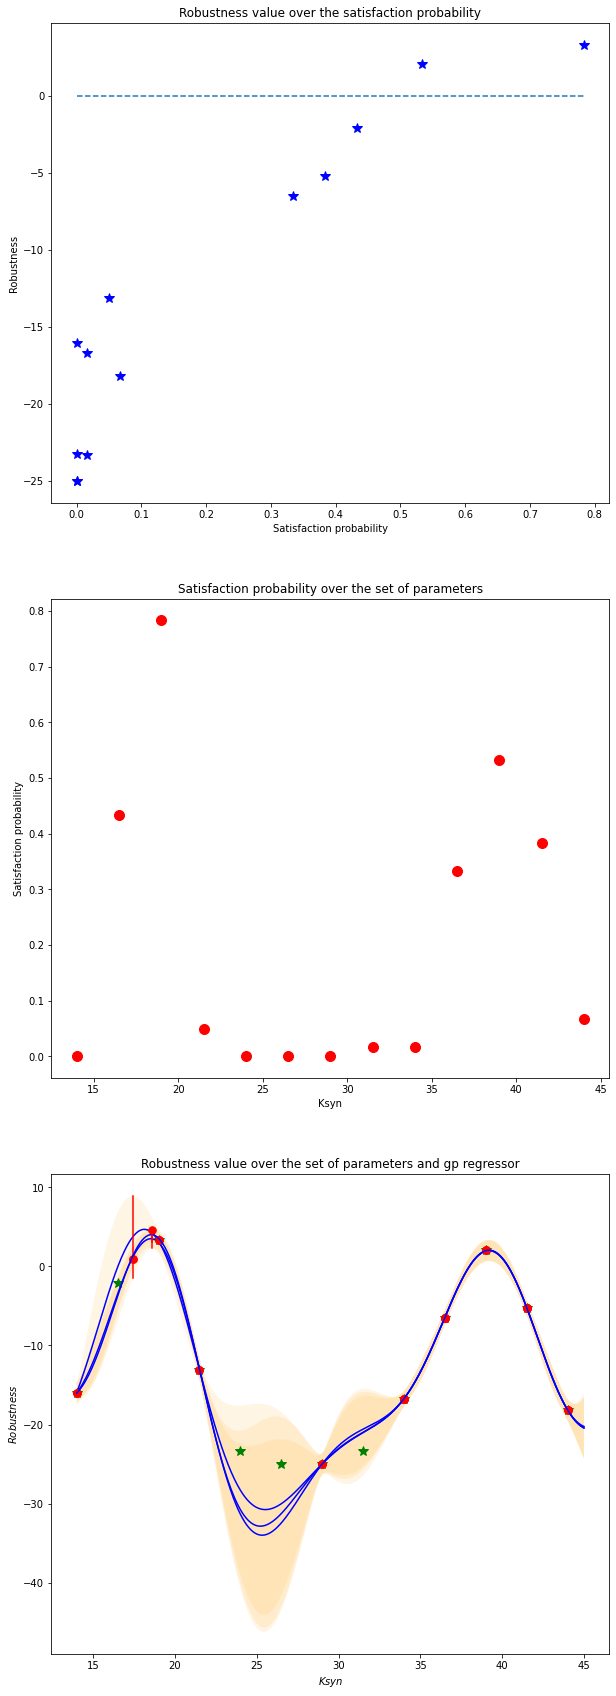

In [25]:
CompleteParameterSynthesis()

### Two-dimension Parameter Space
The stochastic model Immigration-Death has actually two parameters, of which one was fixed during the entire process.
We can extend this algorithm to parameter spaces with more dimension. Clearly, the visual representation can't be clear as it is in one dimension.

